In [39]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import numpy as np
import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

# regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

## Read in files

In [3]:
ca_state = gp.read_file("data/CA_State_TIGER2016.shp")  # CA state
ca_counties = gp.read_file("data/CA_Counties_TIGER2016.shp")  # CA counties
ca_bg = gp.read_file("data/tl_2022_06_bg.shp")  # CA block groups

In [4]:
# Load census block group level data from EJscreen
# Source: https://www.epa.gov/ejscreen/download-ejscreen-data
# This is the 2017-2021 5-year ACS average data
ejscreen = pd.read_excel("data/CA_EJSCREEN_2022_Full_with_AS_CNMI_GU_VI.xlsx", index_col=None, header=0)

In [5]:
# CA social vulnerability data at level of census tract
# source: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
# calenv4_df = gp.read_file("data/CES4 Final Shapefile.shp")
# calenv4_df['Tract'] = calenv4_df['Tract'].astype(np.int64)  # change from float to int

In [6]:
# read in cleaned and combined flares data
all_flares = gp.read_file("data/all_flares.shp")

In [7]:
# set common crs for project
projcrs = 4326
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)
ca_bg = ca_bg.to_crs(projcrs)

ca_bg.rename(columns={'GEOID':'ID'}, inplace=True)  # match column names for merging
ca_bg['ID'] = ca_bg['ID'].astype(np.int64)

In [9]:
print(f"{len(ejscreen['ID'])} block groups in the EJScreen data \n")
print(f"{len(ca_bg['ID'])} block groups in the CA block group shapefile\n")
ca_bg_joined = pd.merge(ca_bg, ejscreen, on='ID')
print(f"{len(ca_bg['ID'].unique())-len(ca_bg_joined)} block groups are missing after merge")

25607 block groups in the EJScreen data 

25607 block groups in the CA block group shapefile

0 block groups are missing after merge


#### Subset flares df to just CA

In [10]:
ca_flares = gp.sjoin(all_flares, ca_counties, how = "inner", predicate = 'within')
print(f'Flares found: {len(ca_flares)}')
ca_flares.drop('index_right', axis=1, inplace=True)

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# add new column for average BCM across all years
ca_flares['BCM_avg'] = ca_flares[col_list].mean(axis=1)  

Flares found: 117


#### Subset BG polygons to only those containing flares

In [11]:
ca_polys_subset = gp.sjoin(ca_bg_joined, ca_flares, how='inner', predicate='contains')

## Regression #1: Are distance (from BG centroid to nearest flare) and social vulnerability predictive of the presence of a flare in a BG?

#### Change to CRS in meters

In [12]:
# epsg3310: https://epsg.io/3310-1739
# units: meters
ca_polys_subset = ca_polys_subset.to_crs(epsg=3310)
ca_flares = ca_flares.to_crs(epsg=3310)
ca_bg_joined = ca_bg_joined.to_crs(epsg=3310)

#### Create new col: distance between BG centroid and nearest flare

In [13]:
ca_bg_joined["dist_flare"] = 0
for i, polygon in enumerate(ca_bg_joined["geometry"]):
    
    has_flare = False
    for point in ca_flares.geometry:
        if polygon.contains(point):
            has_flare = True
    
    if has_flare:
        ca_bg_joined.at[i, "dist_flare"] = 0
    else: 
        centroid = polygon.centroid
        min_dist = ca_flares.geometry.apply(lambda x: centroid.distance(x)).min()
        ca_bg_joined.at[i, "dist_flare"] = min_dist
        
ca_bg_joined["dist_flare"].sort_values()  # print a few values to spot check accuracy

8571          0
2250          0
16375         0
3704          0
12213         0
          ...  
8084     412445
17813    420176
17923    420972
18423    431127
18538    444329
Name: dist_flare, Length: 25607, dtype: int64

In [18]:
# Create "flares present" binary dependent variable
ca_bg_joined = ca_bg_joined.assign(flares_present=ca_bg_joined['geometry'].isin(ca_polys_subset['geometry']).astype(int))

print(f"Block groups containing flares (0=no, 1=yes):\n")
print(ca_bg_joined['flares_present'].value_counts())

Block groups containing flares (0=no, 1=yes):

0    25570
1       37
Name: flares_present, dtype: int64


#### Subset columns to only what's needed for model

In [19]:
allcols=['D_PM25_2', 'dist_flare', 'flares_present']
print(f'there are {ca_bg_joined["D_PM25_2"].isna().sum()} NA values in D_PM25_2')  
for_model = ca_bg_joined[allcols].dropna()  # drop na for now

there are 17 NA values in D_PM25_2


In [20]:
cols=['D_PM25_2', 'dist_flare']
x=for_model[cols]
y=for_model['flares_present']

#### Implement model

In [21]:
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.000108
         Iterations: 35
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.990      
Dependent Variable: flares_present   AIC:              9.5452     
Date:               2023-02-04 12:56 BIC:              25.8451    
No. Observations:   25590            Log-Likelihood:   -2.7726    
Df Model:           1                LL-Null:          -278.92    
Df Residuals:       25588            LLR p-value:      3.9975e-122
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
-------------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|     [0.025    0.975] 
-------------------------------------------------------------------
D_PM25_2     4.6478  462.2095   0.0101  0.9920  -901.2661  910.5617
dist_flare  -0.4552   43.6854  -0.0104  0.9917   -86.0771   85.1667



/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


#### Fit model

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

In [33]:
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 1.0
Test Accuracy: 1.0


In [46]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)
print()
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Confusion Matrix:
 [[6389    0]
 [   0    9]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6389
           1       1.00      1.00      1.00         9

    accuracy                           1.00      6398
   macro avg       1.00      1.00      1.00      6398
weighted avg       1.00      1.00      1.00      6398



Text(0.5, 427.9555555555555, 'Predicted label')

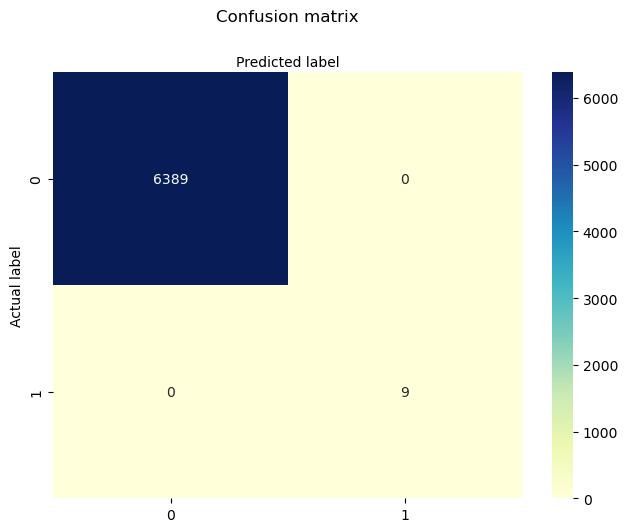

In [47]:
# Visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


### Regression #2: Are distance and social vulnerability predictive of average flaring volume?

In [48]:
allcols=['D_PM25_2', 'dist_flare']
print(f'there are {ca_bg_joined["D_PM25_2"].isna().sum()} NA values in D_PM25_2')  
for_model = ca_bg_joined[allcols].dropna()  # drop na for now

there are 17 NA values in D_PM25_2


In [49]:
cols=['D_PM25_2', 'dist_flare']
x=for_model[cols]
y=ca_flares['BCM_avg']

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

model = LinearRegression()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)


ValueError: Found input variables with inconsistent numbers of samples: [25590, 117]

### How do I reconcile pulling two expl vars from the ca_bg_joined dataset of BG polygons and the response variable 'bcm_avg' from the ca_flares dataset of flare points? Need to align the # of rows somehow